In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler  # Normalizing data
from sklearn.decomposition import PCA  # Principal component
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedKFold
from functions.distance import get_distance, norm_features, split_random

Columns in apartments_and_building files:
"building_id","id","id1","seller","price","area_total","area_kitchen","area_living","floor","rooms","layout","ceiling","bathrooms_shared","bathrooms_private","windows_court","windows_street","balconies","loggias","condition","phones","new","latitude","longitude","district","street","address","constructed","material","stories","elevator_without","elevator_passenger","elevator_service","parking","garbage_chute","heating"

In [2]:
X_Train = pd.read_csv("../data/apartments_and_building_train.csv")
X_Test = pd.read_csv("../data/apartments_and_building_test.csv")

In [3]:
X_Train.head()

,building_id,id,id1,seller,price,area_total,area_kitchen,area_living,floor,rooms,...,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,4365,4365,1023,-9,8000000.0,43.9,NaN,NaN,5,2,...,52К2,1959,0,5,1,0,0,-9,-9,3
1,6025,6025,1024,-9,8000000.0,61.0,NaN,NaN,10,2,...,42к2,2019,2,25,1,1,1,1,1,0
2,918,918,1025,-9,8100000.0,45.0,NaN,NaN,3,2,...,29К2,-9,-9,5,-9,-9,-9,-9,-9,-9
3,2584,2584,1026,-9,8150000.0,45.0,NaN,NaN,1,2,...,63,-9,-9,12,-9,-9,-9,-9,-9,-9
4,1414,1414,1027,-9,8150000.0,43.9,NaN,NaN,5,2,...,вл52,-9,-9,5,-9,-9,-9,-9,-9,-9


In [4]:
# Prepare X
dfTrain = X_Train.copy()  # Keep a copy for tweaking without reloading
dfTest = X_Test.copy()    #

# Set y values
y_train = X_Train["price"]      # Select price only
# y_test = X_Test["price"]  #

In [5]:
# Create new feature "distance"

# Calculate distance to city center with lat/long and add new column
dfTrain["distance"] = dfTrain.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)
dfTest["distance"] = dfTest.loc[:, "latitude":"longitude"].apply(lambda x: get_distance(x.latitude, x.longitude), axis=1)

In [6]:
# Look for outliers
print(dfTrain.iloc[dfTrain["distance"].argmax()])

building_id                  8956
id                           8956
id1                          2329
seller                          2
price                   4000000.0
area_total                   48.0
area_kitchen                  9.0
area_living                  34.0
floor                           4
rooms                           2
layout                         -9
ceiling                       NaN
bathrooms_shared                0
bathrooms_private               1
windows_court                   1
windows_street                  0
balconies                       0
loggias                         1
condition                       1
phones                          1
new                             0
latitude                 55.21143
longitude               37.071199
district                       10
street                пос. Рогово
address                        20
constructed                    -9
material                       -9
stories                         5
elevator_witho

In [7]:
print(dfTest.iloc[dfTest["distance"].argmax()])

building_id                        4636
id                                 4636
id1                               25796
seller                               -9
area_total                         19.8
area_kitchen                        5.1
area_living                         9.4
floor                                11
rooms                                 1
layout                               -9
ceiling                             NaN
bathrooms_shared                     -9
bathrooms_private                    -9
windows_court                        -9
windows_street                       -9
balconies                            -9
loggias                              -9
condition                            -9
phones                                1
new                                   1
latitude                      17.141734
longitude                      -61.7905
district                             -9
street                Бунинские Луга ЖК
address                          к2/2/1


In [8]:
print(dfTrain.iloc[dfTrain["area_total"].argmax()])

building_id                             5745
id                                      5745
id1                                     3217
seller                                    -9
price                           2600000000.0
area_total                            2181.0
area_kitchen                             NaN
area_living                              NaN
floor                                     95
rooms                                      6
layout                                    -9
ceiling                                  NaN
bathrooms_shared                          -9
bathrooms_private                         -9
windows_court                             -9
windows_street                            -9
balconies                                 -9
loggias                                   -9
condition                                  1
phones                                     1
new                                        0
latitude                           55.749511
longitude 

In [9]:
print(dfTest.iloc[dfTest["area_total"].argmax()])

building_id                           2789
id                                    2789
id1                                  32384
seller                                   1
area_total                          1175.0
area_kitchen                          40.0
area_living                          528.0
floor                                   17
rooms                                    6
layout                                   1
ceiling                                NaN
bathrooms_shared                         4
bathrooms_private                        2
windows_court                            1
windows_street                           1
balconies                                2
loggias                                  4
condition                                0
phones                                   2
new                                      0
latitude                         55.714039
longitude                        37.524624
district                                 7
street     

In [10]:
subSet = dfTrain[dfTrain["area_total"] < 1000]
print(subSet.iloc[subSet["area_total"].argmax()])

building_id                         7079
id                                  7079
id1                                 2804
seller                                -9
price                        200000000.0
area_total                         990.0
area_kitchen                        35.0
area_living                        900.0
floor                                 30
rooms                                  6
layout                                -9
ceiling                              7.0
bathrooms_shared                       4
bathrooms_private                      2
windows_court                          1
windows_street                         1
balconies                              0
loggias                                3
condition                              3
phones                                 2
new                                    0
latitude                       55.666675
longitude                      37.510511
district                               7
street          

In [11]:
# Remove outliers

# Distance to center > 80 km
dfTrain_red = dfTrain.copy()
dfTest_red = dfTest.copy()

sub1 = dfTrain_red[~(dfTrain_red["distance"] > 150.0)]
sub2 = dfTest_red[~(dfTest_red["distance"] > 150.0)]
        
#dfTrain_red = dfTrain_red[~(dfTrain_red.loc[:,["distance"]] > 80)]
#dfTest_red= dfTest_red[~(dfTest_red.loc[:,["distance"]] > 80)]

In [12]:
print(dfTrain.shape)
print(sub1.shape)
print(dfTest.shape)
print(sub2.shape)

(23285, 36)
(23285, 36)
(9937, 35)
(9930, 35)


In [13]:
# Normalize continous variables (area_total, distance)

d_mean = dfTrain.loc[:,["area_total", "distance"]].mean(axis=0)
d_std = dfTrain.loc[:,["area_total", "distance"]].std(axis=0)
dfTrain.loc[:,["area_total", "distance"]] = (dfTrain.loc[:,["area_total", "distance"]] - d_mean)/ (1.0 * d_std) 

norm_features(dfTest.loc[:,["area_total", "distance"]])

,area_total,distance
0,0.121644,-0.038211
1,0.371825,-0.028061
2,0.387794,-0.028061
3,0.724916,-0.023811
4,0.724916,-0.023811
...,...,...
9932,0.547483,-0.034510
9933,0.121644,-0.057016
9934,-0.458562,-0.013152
9935,-0.644866,-0.059799


In [14]:
dfTrain.head()

,building_id,id,id1,seller,price,area_total,area_kitchen,area_living,floor,rooms,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,4365,4365,1023,-9,8000000.0,-0.520714,NaN,NaN,5,2,...,1959,0,5,1,0,0,-9,-9,3,-0.488993
1,6025,6025,1024,-9,8000000.0,-0.229260,NaN,NaN,10,2,...,2019,2,25,1,1,1,1,1,0,0.840435
2,918,918,1025,-9,8100000.0,-0.501965,NaN,NaN,3,2,...,-9,-9,5,-9,-9,-9,-9,-9,-9,0.543485
3,2584,2584,1026,-9,8150000.0,-0.501965,NaN,NaN,1,2,...,-9,-9,12,-9,-9,-9,-9,-9,-9,0.354380
4,1414,1414,1027,-9,8150000.0,-0.520714,NaN,NaN,5,2,...,-9,-9,5,-9,-9,-9,-9,-9,-9,-0.518539


In [15]:
dfTest.head()

,building_id,id,id1,seller,area_total,area_kitchen,area_living,floor,rooms,layout,...,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating,distance
0,2322,2322,24308,-9,82.0,NaN,NaN,2,2,-9,...,2012,2,22,1,1,1,0,1,0,10.240668
1,7824,7824,24309,-9,96.1,21.5,NaN,5,1,-9,...,2019,2,26,1,1,1,0,0,-9,12.317027
2,7824,7824,24310,-9,97.0,15.0,NaN,18,3,-9,...,2019,2,26,1,1,1,0,0,-9,12.317027
3,8468,8468,24311,-9,116.0,13.0,72.0,2,3,-9,...,2009,2,24,0,1,1,0,0,-9,13.186469
4,8468,8468,24312,-9,116.0,30.0,85.0,2,4,-9,...,2009,2,24,0,1,1,0,0,-9,13.186469


In [16]:
# Features without any NaN (in training set)
d = dfTrain.copy()
d = d.loc[:,["area_total", "floor", "rooms", "stories", "distance"]]

In [17]:
d.head()

,area_total,floor,rooms,stories,distance
0,-0.520714,5,2,5,-0.488993
1,-0.229260,10,2,25,0.840435
2,-0.501965,3,2,5,0.543485
3,-0.501965,1,2,12,0.354380
4,-0.520714,5,2,5,-0.518539


In [18]:
pca_model = PCA(n_components=3)

In [19]:
pca_train = pca_model.fit_transform(d)

In [20]:
pca_train_Df = pd.DataFrame(data = pca_train
             , columns = ['principal 1', 'principal 2', 'principal 3'])

In [21]:
pca_train_Df.head()

,principal 1,principal 2,principal 3
0,-12.745616,-3.509726,-0.085973
1,6.752297,3.146572,-0.666709
2,-13.840414,-1.836369,-0.398801
3,-9.048403,3.646021,-0.401090
4,-12.745359,-3.509563,-0.076011


In [22]:
print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))

Explained variation per principal component: [0.84025319 0.14411188 0.00957205]


In [23]:
# Split in test/train on training set
d = dfTrain.copy()

# Add the PCA components?
d["principal 1"] = pca_train_Df["principal 1"]
d["principal 2"] = pca_train_Df["principal 2"]

d["price"] = norm_features(d["price"])  # is the same as z-scores
d = d.loc[:,["price", "area_total", "floor", "rooms", "stories", "distance", "principal 1", "principal 2"]] 

x1, y1, x2, y2 = split_random(d, 0.7)


In [24]:
x_test = x1.copy()
y_test = y1.copy()
x_train = x2.copy()
y_train = y2.copy()

In [25]:
print(x1.shape)
print(x2.shape)
x1.head()

(16299, 7)
(6986, 7)


,area_total,floor,rooms,stories,distance,principal 1,principal 2
4756,-0.660475,10,1,12,0.958914,-4.175594,-3.911501
5121,-0.432085,7,1,23,1.167948,3.431266,4.579460
10919,-0.563324,5,1,17,2.856913,-2.708431,2.991169
21627,-0.510487,3,2,9,-0.899555,-10.470014,0.344303
9409,0.533633,13,3,17,-0.997173,1.699789,-3.713399


In [26]:
print(y1.shape)
print(y2.shape)
y1.head()

(16299, 1)
(6986, 1)


,price
4756,-0.320762
5121,-0.323991
10919,-0.311644
21627,-0.274603
9409,0.196014


In [27]:
# Set up a regression model
reg_model = LinearRegression()

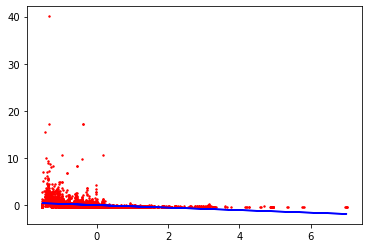

In [28]:
# Train the model
reg_model.fit(x1["distance"].values.reshape(-1, 1), y1.values.reshape(-1, 1))

# Test the model
y_pred = reg_model.predict(x2["distance"].values.reshape(-1, 1))
plt.scatter(x2["distance"], y2, s=2, color = 'red')
plt.plot(x2["distance"], reg_model.predict(x2["distance"].values.reshape(-1, 1)), color = 'blue')

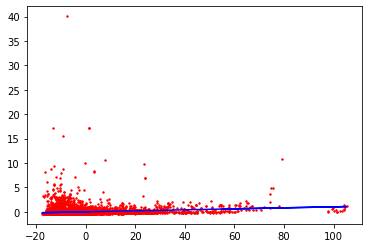

In [29]:
# Train the model
reg_model.fit(x1["principal 1"].values.reshape(-1, 1), y1.values.reshape(-1, 1))

# Test the model
y_pred = reg_model.predict(x2["principal 1"].values.reshape(-1, 1))
plt.scatter(x2["principal 1"], y2, s=2, color = 'red')
plt.plot(x2["principal 1"], reg_model.predict(x2["principal 1"].values.reshape(-1, 1)), color = 'blue')

Text(0.5, 1.0, 'hp')

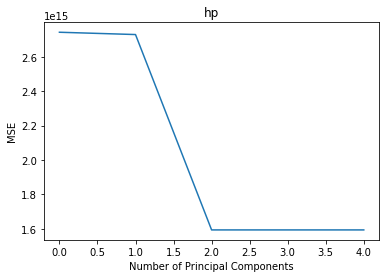

In [30]:
y = dfTrain["price"]
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
mse = []

for i in np.arange(1, 6):
    score = -1*model_selection.cross_val_score(reg_model,
               pca_train[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)
    
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('hp')

In [31]:
np.cumsum(np.round(pca_model.explained_variance_ratio_, decimals=4)*100)

array([84.03, 98.44, 99.4 ])

In [32]:
regPCA = LinearRegression()
regPCA.fit(pca_train, y)

LinearRegression()

In [33]:
predPCA = regPCA.predict(pca_test, dfTest["price"])
np.sqrt(mean_squared_error(dfTest["price"], predPCA))

NameError: name 'pca_test' is not defined